In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import gradio as gr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time
import os
import io
from PIL import Image
import base64
import requests
from transformers import BlipProcessor, BlipForConditionalGeneration

## Data Preprocessing

In [22]:
dataset_path = "C:/Users/priya/OneDrive/Desktop/2750"

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
dataset = ImageFolder(dataset_path, transform=train_transform)
dataset_classes = dataset.classes

print(dataset.classes)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [23]:
# Split dataset
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# Update transforms
train_ds.dataset.transform = train_transform
val_ds.dataset.transform = test_transform
test_ds.dataset.transform = test_transform

# Dataloaders
batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3301654..0.8447932].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4671633..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3301654..1.8905448].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5699118..-0.09638336].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6384109..-0.42753804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5014129..0.65307206].


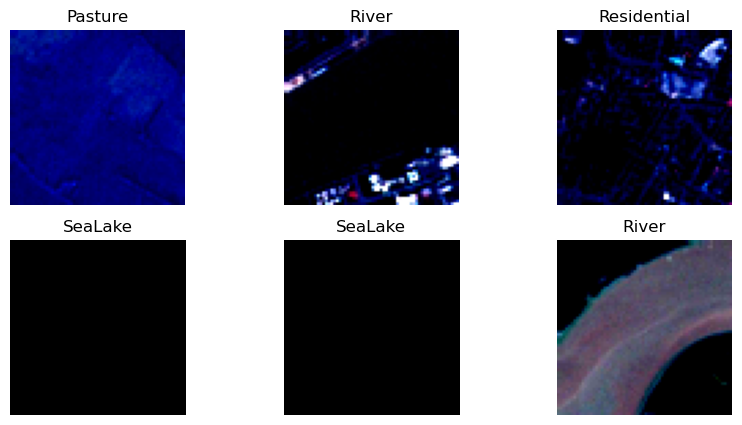

In [24]:
# Get one batch from train loader
images, labels = next(iter(train_loader))

# Function to show image
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # CHW -> HWC
    plt.imshow(img)
    plt.axis('off')

# Show first 6 images in batch
plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    imshow(images[i])
    plt.title(dataset.classes[labels[i]])
plt.show()

## Model Selection, Architecture and Training

In [25]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define train_and_evaluate function with tracking and plotting
def train_and_evaluate(lr, batch_size, num_epochs=5, patience=1):
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, len(dataset_classes))
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_acc = 0
    patience_counter = 0

    train_losses = []
    val_accuracies = []
    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f} Acc: {epoch_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), f"best_model_lr{lr}_bs{batch_size}.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
    # Plot accuracy and loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Loss (lr={lr}, bs={batch_size})')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc', marker='o')
    plt.plot(val_accuracies, label='Val Acc', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Training & Validation Accuracy (lr={lr}, bs={batch_size})')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    return best_val_acc, f"best_model_lr{lr}_bs{batch_size}.pth"

## Hyperparameter Tuning

Epoch [1/5] Loss: 1.0177 Acc: 64.24% | Val Acc: 74.22%
Epoch [2/5] Loss: 0.7225 Acc: 74.12% | Val Acc: 76.59%
Epoch [3/5] Loss: 0.5646 Acc: 80.30% | Val Acc: 85.19%
Epoch [4/5] Loss: 0.4554 Acc: 83.93% | Val Acc: 81.22%
Early stopping triggered.


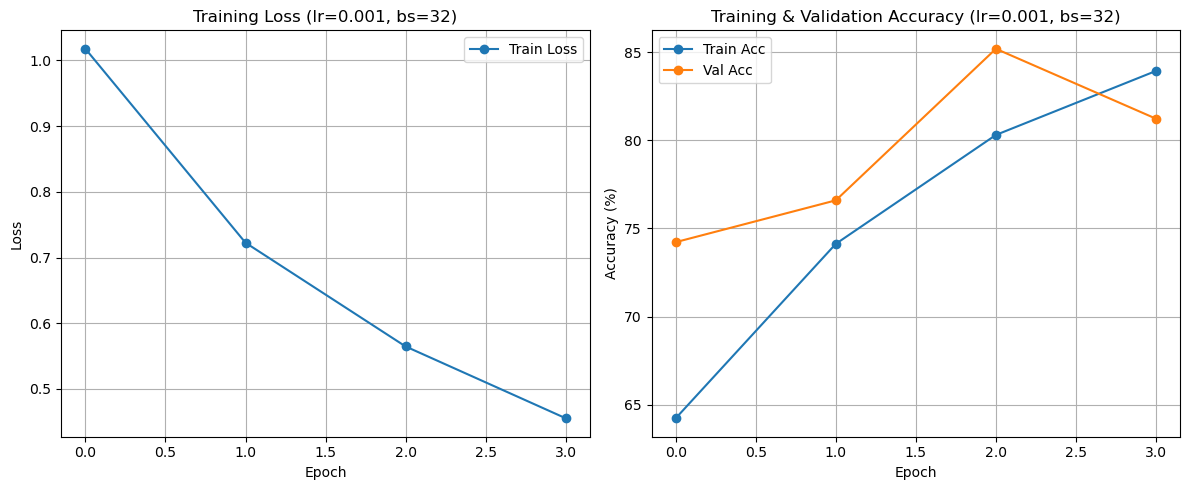

Epoch [1/5] Loss: 0.9296 Acc: 66.56% | Val Acc: 68.30%
Epoch [2/5] Loss: 0.6362 Acc: 77.72% | Val Acc: 79.70%
Epoch [3/5] Loss: 0.5041 Acc: 82.42% | Val Acc: 73.81%
Early stopping triggered.


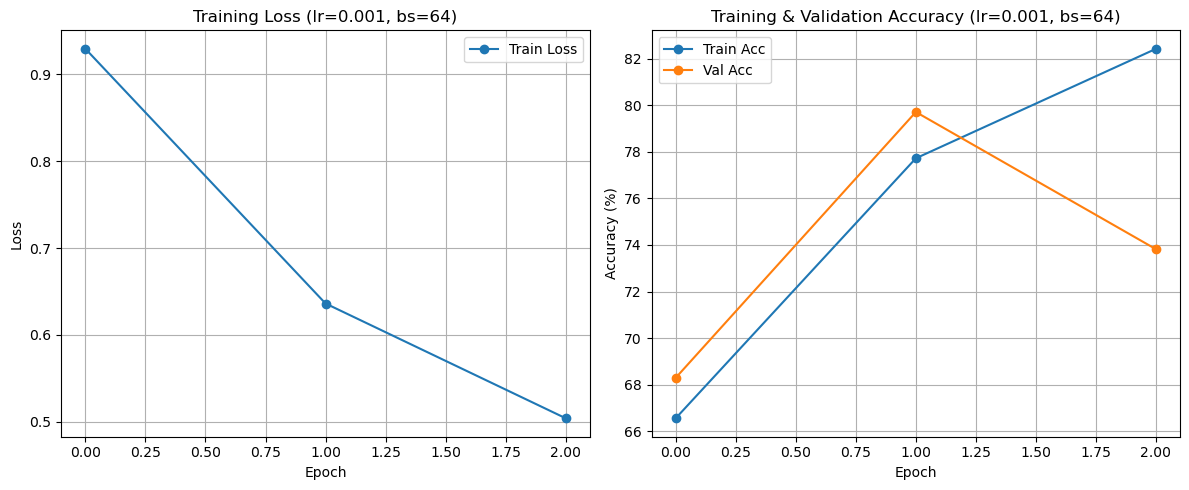

C:\Users\priya\anaconda3\envs\dl-pytorch\lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
C:\Users\priya\AppData\Local\Temp\ipykernel_27352\3820754826.py:52: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)
C:\Users\priya\AppData\Local\Temp\ipykernel_27352\3820754826.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('jet')


Epoch [1/5] Loss: 0.9304 Acc: 66.96% | Val Acc: 71.48%
Epoch [2/5] Loss: 0.6031 Acc: 78.91% | Val Acc: 78.41%
Epoch [3/5] Loss: 0.4873 Acc: 82.97% | Val Acc: 82.30%
Epoch [4/5] Loss: 0.3831 Acc: 86.59% | Val Acc: 77.22%
Early stopping triggered.


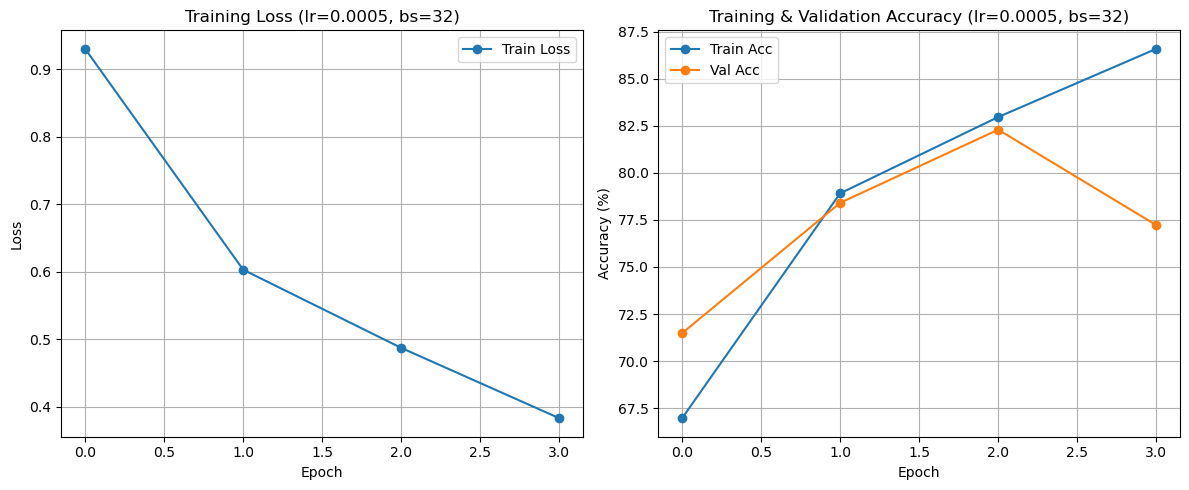

Epoch [1/5] Loss: 0.8329 Acc: 70.49% | Val Acc: 66.00%
Epoch [2/5] Loss: 0.5403 Acc: 81.08% | Val Acc: 78.89%
Epoch [3/5] Loss: 0.4248 Acc: 85.12% | Val Acc: 81.22%
Epoch [4/5] Loss: 0.3347 Acc: 88.32% | Val Acc: 81.07%
Early stopping triggered.


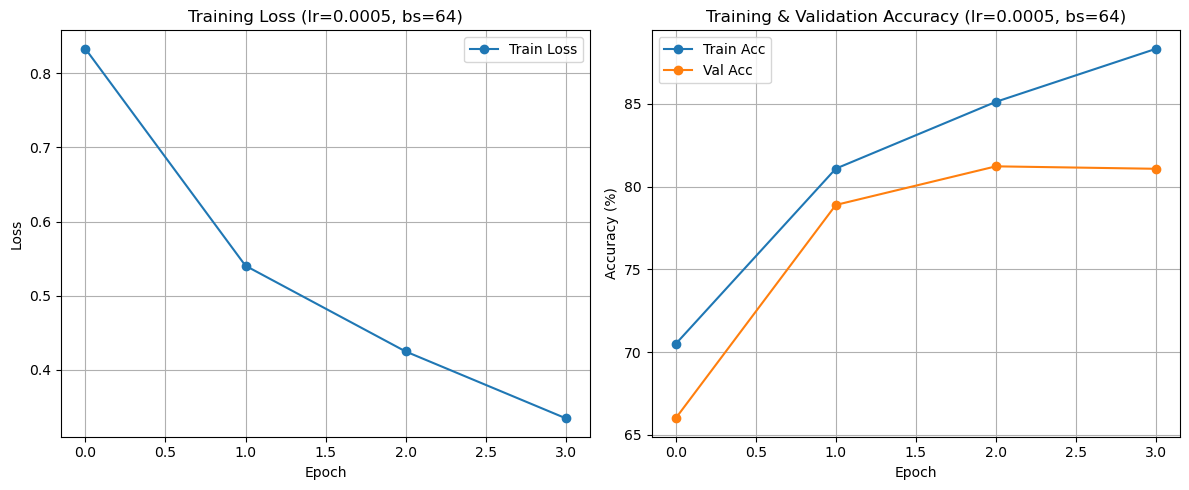


Best hyperparameters: lr=0.001, batch_size=32 with val accuracy 85.19%


In [26]:
# Hyperparameter tuning
learning_rates = [0.001, 0.0005]
batch_sizes = [32, 64]

best_overall_acc = 0
best_model_path = None
best_params = {}

for lr in learning_rates:
    for bs in batch_sizes:
        val_acc, model_path = train_and_evaluate(lr, bs)
        if val_acc > best_overall_acc:
            best_overall_acc = val_acc
            best_model_path = model_path
            best_params = {'lr': lr, 'batch_size': bs}

print(f"\nBest hyperparameters: lr={best_params['lr']}, batch_size={best_params['batch_size']} with val accuracy {best_overall_acc:.2f}%")

## Evaluation

In [28]:
# Load best model and evaluate on test set
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(dataset_classes))
model = model.to(device)
model.load_state_dict(torch.load(best_model_path))
model.eval()

test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")

Test Accuracy: 82.96%



Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.91      0.79      0.84       291
              Forest       0.96      0.91      0.93       296
HerbaceousVegetation       0.83      0.70      0.76       299
             Highway       0.81      0.51      0.62       235
          Industrial       0.95      0.89      0.92       260
             Pasture       0.79      0.81      0.80       223
       PermanentCrop       0.63      0.86      0.73       240
         Residential       0.90      0.95      0.92       280
               River       0.65      0.90      0.75       271
             SeaLake       0.95      0.94      0.95       305

            accuracy                           0.83      2700
           macro avg       0.84      0.82      0.82      2700
        weighted avg       0.84      0.83      0.83      2700



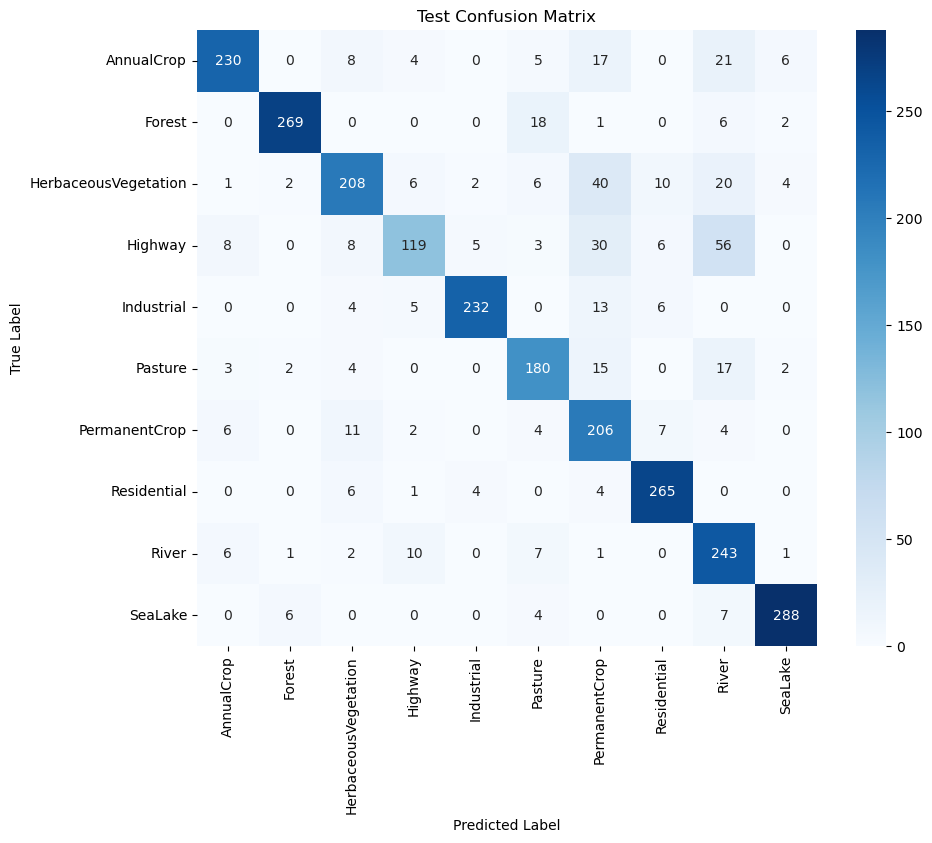

In [29]:
# Report and confusion matrix
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset_classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=dataset_classes, yticklabels=dataset_classes, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Confusion Matrix")
plt.show()

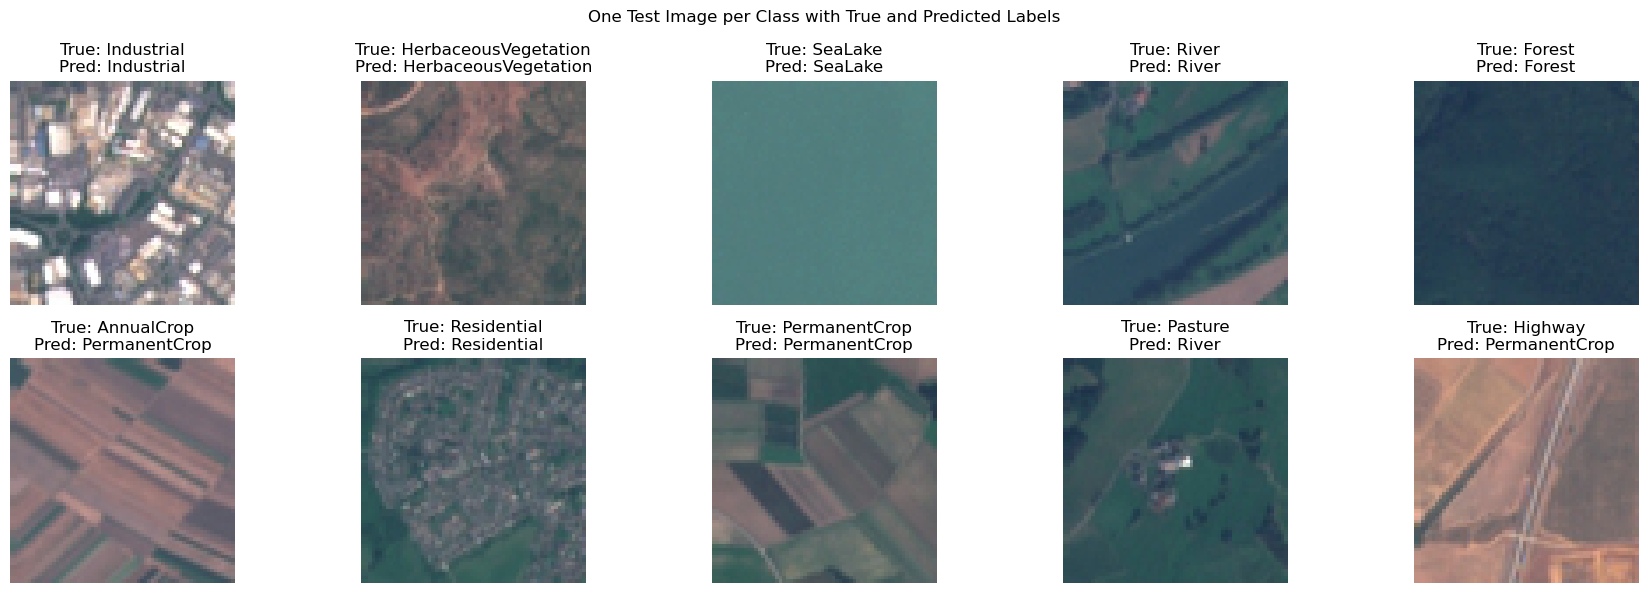

In [30]:
# Make sure model is in eval mode
model.eval()

# Dictionary to hold one example image per class
class_examples = {}
max_classes = len(dataset_classes)

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # Iterate through batch
        for img, label, pred in zip(images, labels, preds):
            class_id = label.item()
            # If we don't have an example for this class yet, save it
            if class_id not in class_examples:
                class_examples[class_id] = (img.cpu(), label.cpu(), pred.cpu())

            # Stop if we have one image per class
            if len(class_examples) == max_classes:
                break
        if len(class_examples) == max_classes:
            break

# Function to unnormalize and convert tensor to numpy image (same as before)
def imshow(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img_tensor.numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# Plot images, true labels, predicted labels
plt.figure(figsize=(18, 6))
for i, (class_id, (img, label, pred)) in enumerate(class_examples.items()):
    plt.subplot(2, (max_classes + 1) // 2, i + 1)
    plt.imshow(imshow(img))
    true_label = dataset_classes[label.item()]
    pred_label = dataset_classes[pred.item()]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

plt.suptitle("One Test Image per Class with True and Predicted Labels")
plt.tight_layout()
plt.show()

## Building an Interactive Gradio App

In [31]:
# Initialize BLIP processor and model once globally
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

# Define transform globally
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def classify_and_explain(img):
    # Prepare tensor for CNN
    img_tensor = test_transform(img).unsqueeze(0).to(device)

    # CNN prediction
    with torch.no_grad():
        output = model(img_tensor)
        _, pred = torch.max(output, 1)
        predicted_class = dataset_classes[pred.item()]

    # Grad-CAM heatmap generation
    heatmap = gradcam.generate(img_tensor, class_idx=pred.item())
    overlay_img = overlay_heatmap_on_image(img, heatmap)

    # Multimodal LLM explanation with BLIP
    inputs = blip_processor(img, return_tensors="pt").to(device)
    outputs = blip_model.generate(**inputs)
    llm_explanation = blip_processor.decode(outputs[0], skip_special_tokens=True)

    # Return both predictions + explanations
    return predicted_class, overlay_img, f"CNN Grad-CAM Explanation: {predicted_class}", f"LLM Explanation: {llm_explanation}"

# Gradio interface with 4 outputs
interface = gr.Interface(
    fn=classify_and_explain,
    inputs=gr.Image(type="pil", label="Upload Satellite Image"),
    outputs=[
        gr.Textbox(label="Predicted Class"),
        gr.Image(label="Grad-CAM Heatmap Overlay"),
        gr.Textbox(label="CNN Explanation"),
        gr.Textbox(label="Multimodal LLM Explanation"),
    ],
    title="Satellite Image Classification with Grad-CAM and Multimodal LLM Explanation",
    description="Upload a satellite image to see CNN prediction with Grad-CAM and multimodal LLM explanation side-by-side."
)

interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7864
* Running on public URL: https://3b92ddd2f65043a04c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
